# NLP project

An project on natural language processing at Xccelerate HK. The task is to summarize a news article in four sentences.

For the NLP corpus a script is written to scrape all articles from theonion.com. The target article from CNN is stemmed and have the stop words removed. And then it is vectorized by tfidf rules with the corpus scraped from the onion. The tfidf score is computed for each tokenized sentence, and the four with the highest scores are returned as the summary for the article.

Finally the articles in the corpus are separated into 10 clusters by Kmeans. The cluster number will then be used as output labels to train various classifier models whose accuracy scores are compared.

In [1]:
import requests
from bs4 import BeautifulSoup
from nltk.corpus import wordnet, stopwords
from nltk.wsd import lesk
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, sent_tokenize, \
    pos_tag, bigrams
from string import punctuation
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [7]:
PATH = 'data/'
# nonascii punctuations that the articles may use
PUNC_LIST = ".-—‘’“”"  + punctuation
STOP_WORDS = stopwords.words('english')
STEMMER = SnowballStemmer('english')

In [3]:
# create a list of stopwords that are stemmed by
# the same stammer we use
stemmed_stop_words = []
for word in STOP_WORDS:
    stem_stop = STEMMER.stem(word)
    if stem_stop not in stemmed_stop_words:
        stemmed_stop_words.append(stem_stop)

In [9]:
# load the whole corpus
corpus_path = PATH + 'articles.csv'
cnn_path = PATH + 'CNN_article.txt'
# https://edition.cnn.com/2018/12/04/politics/robert-mueller-donald-trump-michael-flynn-paul-manafort-russia-investigation/index.html
corpus = []
articles = []
with open(corpus_path, 'r', encoding='utf-8') as articles_f:
    reader = csv.DictReader(articles_f)
    for row in reader:
        if len(row['text']) > 30:
            corpus.append(row['title'] + ' ' + row['text'])
            articles.append(row)

            
# get the particular article to summarize
with open(cnn_path, 'r', encoding='utf-8') as cnn_f:
    cnn_article = cnn_f.read()

 

In [10]:
def preprocess(text_list, stop_words, stemmer):
    '''
    Turns the list of strings into all lowercase, replaces all punctuations
    with spaces, tokenizes, stems the words, removes any stopwords and then 
    rejoins the words.
    
    :param text_list: list of strings. List of text to be processed
    :param stopwords: list of strings. List of stopwords. Note that the stopwords
        have to be stemmed with the same stemmer
    :param stemmer: stemmer object. an object with the method stem() that stems
    a word
    :returns: list of strings. Same structure as text_list, processed.
    '''    
    result = []
    # change the dashes and hyphens into spaces as tokenizer cant seem to find them
    replace_list = PUNC_LIST
    remove_punc = str.maketrans(replace_list, ' ' * len(replace_list))
    for text in text_list:
        clean_text = text.lower().translate(remove_punc)
        tokens = word_tokenize(clean_text)
        # Stem each token and then rejoin them with spaces, and appened that
        # to result
        stemmed_tokens = []
        for token in tokens:
            stemmed_token = stemmer.stem(token)
            if stemmed_token not in stop_words:
                stemmed_tokens.append(stemmed_token)
        result.append(' '.join(stemmed_token for stemmed_token in stemmed_tokens))
    return result


In [11]:
# "train" the vectorizer on the whole corpus, with bigrams
vec_2gram = text.TfidfVectorizer(
    strip_accents='unicode', 
    ngram_range=(1,2)
)
vec_2gram.fit(preprocess(corpus, STOP_WORDS, STEMMER))
print(len(vec_2gram.get_feature_names()))

43327


In [7]:
# summarize one article
def summarize(text, vectorizer, stop_words, stemmer):
    '''
    Returns the summary of an article.
    :param text: string. Text to be summarized
    :param vectorizer: vectorizer object that is already trained and has a 
    fit() method
    :param stopwords: list of strings. List of stopwords. Note that the stopwords
        have to be stemmed with the same stemmer
    :param stemmer: stemmer object. an object with the method stem() that stems
    a word
    :returns: string. A four sentence summary of the text
    '''
    
    # split the text into sentences
    sentences = sent_tokenize(text)
    if len(sentences) < 4:
        print('Text is too short to summarize')
        return None
    p_sentences = preprocess(sentences, stop_words, stemmer)
    # get the Tfidf score matrix
    scores = vectorizer.transform(p_sentences)
    sentence_strengths = []
    # get the sum of scores for each sentence
    for sentence_score in scores:
        sentence_strengths.append(sentence_score.sum())
    sentence_strengths = pd.Series(sentence_strengths)
    # get the indices of the top 4 sentences in strength
    indices = sentence_strengths.sort_values(ascending=False).head(4).index
    
    return '\n\n'.join(sentences[i] for i in indices.sort_values())



### Summary of the article

In [10]:
print(summarize(cnn_article, vec_2gram, STOP_WORDS, STEMMER))

Court filings focusing on Trump's first national security adviser, Michael Flynn, on Tuesday and his ex-campaign chairman Paul Manafort on Friday could offer tantalizing new details of Mueller's deep dive into the 2016 campaign.

Stepping up the pace of his probe since the midterm elections, Mueller has moved in a direction that appears increasingly threatening to the President, including his crossing of Trump's red line by showing interest in his family real estate empire.

Another branch of Mueller's investigation is also emerging -- his interest in alleged communications between Trump's informal political adviser Roger Stone and associate Jerome Corsi with WikiLeaks, the website that published emails stolen by Russian spies from the Clinton campaign's chairman and the Democratic National Committee.

There was another example of suspicious timing in the Cohen indictment last week: Prosecutors revealed that Trump's fixer called off plans to visit Russia for the proposed Trump Tower Mo

### Extra excercise - clustering the articles in the corpus

In [11]:
# Cluster and classify articles
articles_tfidf_2gram = vec_2gram.transform(preprocess(corpus, STOP_WORDS, STEMMER))
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(articles_tfidf_2gram)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [12]:
df = pd.DataFrame(articles_tfidf_2gram.toarray())
df['cluster'] = kmeans.predict(df)
df_x = df.drop('cluster', axis=1)

In [13]:
for i in range(len(df)):
    articles[i]['cluster'] = df.cluster.iloc[i]
articles_df = pd.DataFrame(articles)

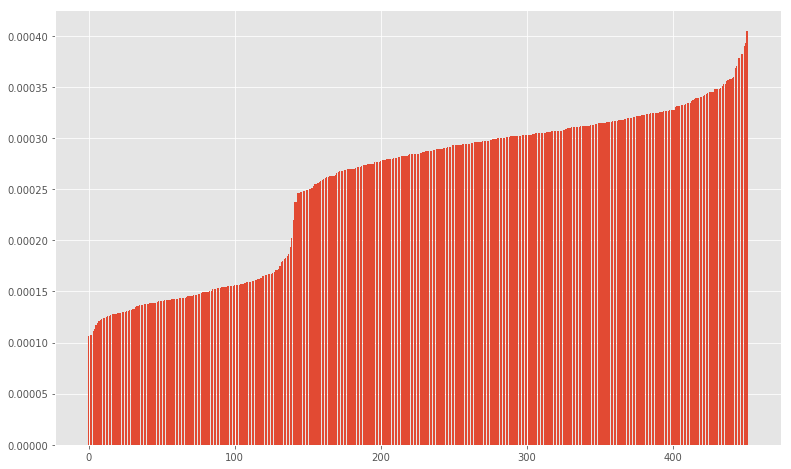

In [154]:
# a little EDA
pd.options.display.max_rows = 20
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 8) #deault figure size
plt.style.use('ggplot') #make plot prettier

# mean scores across features of each article
plt.bar(x=range(452), height=df_x.mean(axis=1).sort_values())
plt.show()

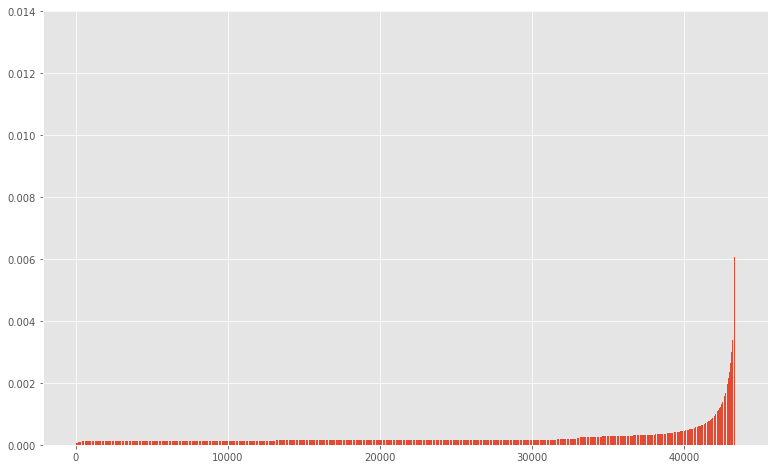

In [132]:
# mean scores across articles of each feature
plt.bar(x=range(len(df_x.columns)), height=df_x.mean(axis=0).sort_values())
plt.show()

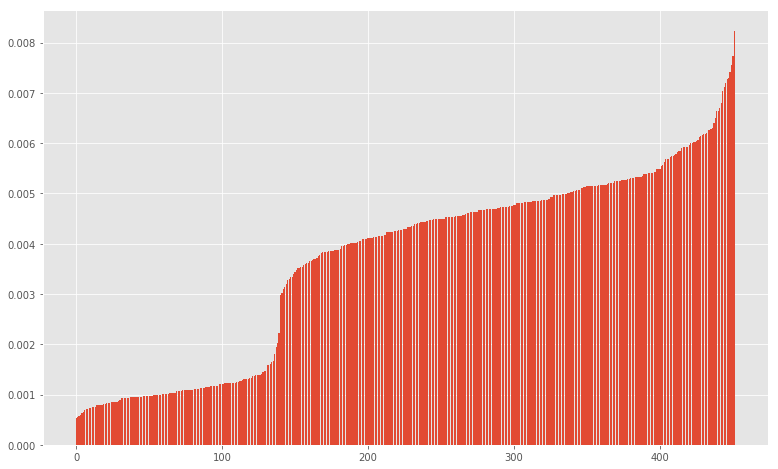

In [145]:
# proportion of features with non-zero values across articles
plt.bar(x=range(len(df)), height=(df_x != 0).mean(axis=1).sort_values())
plt.show()

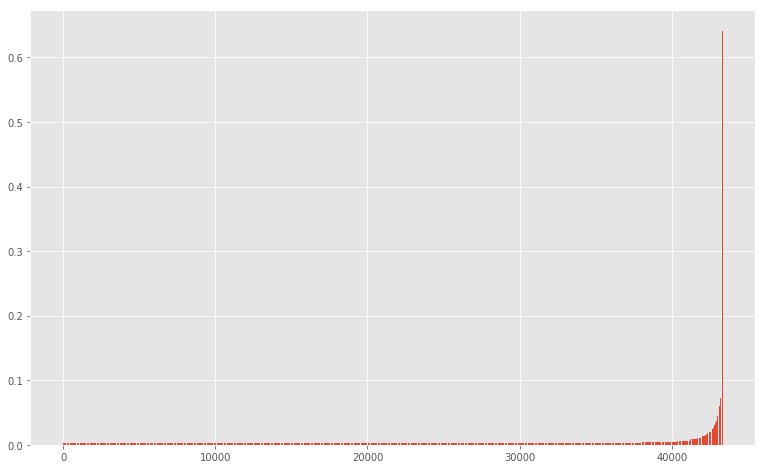

In [146]:
# proportion of non-zero feature scores among all articles of each feature
plt.bar(x=range(len(df_x.columns)), height=(df_x != 0).mean(axis=0).sort_values())
plt.show()

Number of PCs: 200
Total explained variance: 0.5091124623422548
------------------------------
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.004967  0.010534 -0.030667  0.046978  0.013039  0.024608 -0.001111   
1 -0.031828 -0.007884 -0.042194  0.036015  0.000812  0.012932  0.014745   
2 -0.039543 -0.039782 -0.011935 -0.018009 -0.050450 -0.033300 -0.009658   
3 -0.022009  0.031255 -0.032650  0.015366  0.025475  0.035626 -0.014741   
4 -0.011261  0.016448 -0.026982  0.021357  0.031655  0.019225 -0.022217   

        PC8       PC9      PC10    ...        PC191     PC192     PC193  \
0  0.002723  0.016133 -0.026313    ...     0.074081  0.061612  0.027121   
1  0.061240 -0.023964 -0.008834    ...     0.026357 -0.027281 -0.048884   
2  0.035158 -0.012963 -0.001216    ...     0.032604  0.008352  0.019170   
3 -0.116771  0.033952 -0.078824    ...    -0.072745  0.053041  0.067195   
4 -0.054032  0.015464 -0.058584    ...     0.005098  0.017600  0.010965   

   

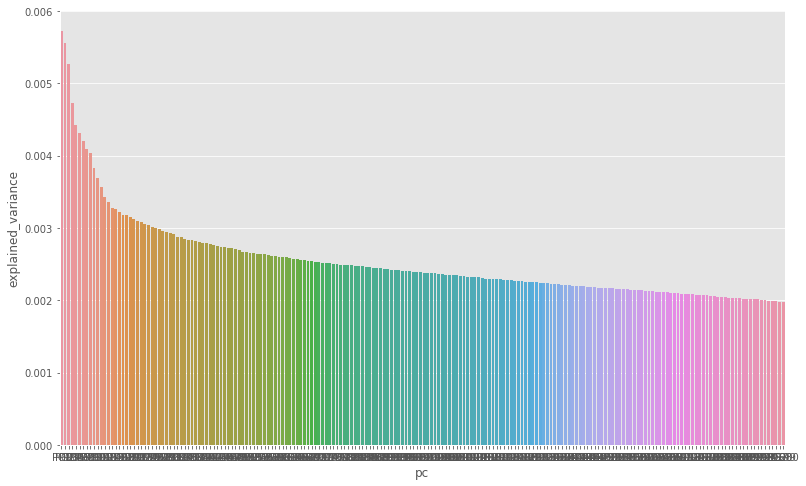

PCA completed


(PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0   -0.004967  0.010534 -0.030667  0.046978  0.013039  0.024608 -0.001111   
 1   -0.031828 -0.007884 -0.042194  0.036015  0.000812  0.012932  0.014745   
 2   -0.039543 -0.039782 -0.011935 -0.018009 -0.050450 -0.033300 -0.009658   
 3   -0.022009  0.031255 -0.032650  0.015366  0.025475  0.035626 -0.014741   
 4   -0.011261  0.016448 -0.026982  0.021357  0.031655  0.019225 -0.022217   
 5   -0.027836 -0.016067 -0.023088  0.018268 -0.027410 -0.023961 -0.020408   
 6   -0.030186 -0.031899 -0.034619  0.022845 -0.089790 -0.071273 -0.001354   
 7    0.053947  0.117317  0.094021 -0.054290  0.044389  0.021007 -0.029206   
 8   -0.024432 -0.037402 -0.034630  0.006430 -0.100708 -0.019851  0.006794   
 9   -0.006263  0.051222 -0.015002  0.048093  0.020830  0.063840 -0.055430   
 10  -0.027804 -0.01

<Figure size 936x576 with 0 Axes>

In [104]:
def do_PCA(n, features_data, random_state=None, print_result=False):
    '''
    Takes an array of feature_data and performs a PCA.
    
    Parameters:
    ----------
    n: int
        number of components to keep in the PCA. Unlike the standard PCA
        object, cannont take None or decimals.
        
    features_data: np.array
        numpy array of feature data. shape has to match the row number 
        of target data.
        
    random_state: int, optional
        random seed for both the RandomForestRegressor and the cross
        validation splits
        
    print_result: bool, defaults to False
        if True, print the details of the PCA results
    
    Returns:
    ----------
    PCA object
        object containing the info of the transformation.
    
    DataFrame object
        data after the PCA transformation, with nice column names
    '''
      
      
    # PCA
    pc_list = ["PC"+str(i) for i in range(1,n+1)]
    pca = PCA(n, random_state=random_state)
    x_pca = pca.fit_transform(features_data)
    df_pca = pd.DataFrame(x_pca, columns=pc_list)
    
    # plotting explained variance
    df_explained_variance = pd.DataFrame({
        "pc": pc_list, 
        "explained_variance": pca.explained_variance_ratio_
    })

    print("Number of PCs:", n)
    print("Total explained variance:", sum(pca.explained_variance_ratio_))

    # option to print results
    if print_result:
        # checking results
        print("-"*30)
        print(df_pca.head())
        barplot = sns.barplot(
            x="pc", 
            y="explained_variance",
            data=df_explained_variance
        )
        plt.show()
        plt.clf()
    
    print ("PCA completed")
    return pca, df_pca


do_PCA(200, df.drop('cluster', axis=1), print_result=False)

Not surprising to see a very sparse matrix. 
PCA explained variance curve is rather gradual and it doesn't seem like PCA will help much

In [29]:
for i in range(10):
    print(f'\n\nCluster {i}:')
    print(articles_df[articles_df.cluster == i].category.value_counts())  



Cluster 0:
News in Brief      21
American Voices    15
Infographic         1
Name: category, dtype: int64


Cluster 1:
News in Brief           64
American Voices          9
Sports News In Brief     2
News                     1
Horoscopes               1
Name: category, dtype: int64


Cluster 2:
News in Brief           47
American Voices         11
Infographic              7
Commentary               1
Horoscopes               1
Sports News In Brief     1
Name: category, dtype: int64


Cluster 3:
American Voices    17
News in Brief      15
Horoscopes          6
Infographic         4
Lifestyle           1
Name: category, dtype: int64


Cluster 4:
News in Brief      21
American Voices     8
Infographic         1
Name: category, dtype: int64


Cluster 5:
News in Brief           36
American Voices         11
Sports News In Brief     4
Infographic              2
News                     1
Horoscopes               1
                         1
Name: category, dtype: int64


Cluster 6:
News in

In [14]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_x, df.cluster, test_size=0.2, random_state=42
)


In [36]:
knn = KNeighborsClassifier(n_neighbors=43, weights='distance')
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.5934065934065934

In [23]:
sv_classifier = SVC(
    C=1.0,
    kernel='linear',
    decision_function_shape='ovr',
    random_state=42   
)
sv_classifier.fit(x_train, y_train)
sv_classifier.score(x_test, y_test)

0.3626373626373626

In [26]:
rfc = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    max_leaf_nodes=None    
)
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.3626373626373626

In [28]:
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)
ada.score(x_test, y_test)

0.17582417582417584